In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
import random

In [2]:
out_dir = Path("../phys-vae/data/climate/")

In [3]:
data = pd.read_parquet("complete_data.parquet")

In [4]:
# Replace -9999 with NaN
data['NEE'] = data['NEE'].replace(-9999, np.nan)

# Identify the consecutive gaps
data['Gap'] = data['NEE'].isna().astype(int).groupby(data['NEE'].notna().astype(int).cumsum()).cumsum()

# Filter out the zero values and calculate the lengths of the gaps
gap_lengths = data[data['Gap'] != 0]['Gap'].value_counts().reset_index()
gap_lengths.columns = ['Gap Length', 'Frequency']

gap_lengths

,Gap Length,Frequency
0,1,8619
1,2,4881
2,3,3767
3,4,3013
4,5,2540
...,...,...
810,751,1
811,749,1
812,748,1
813,747,1


<BarContainer object of 815 artists>

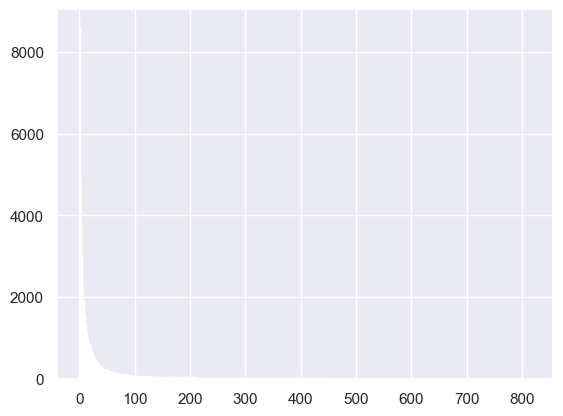

In [5]:
plt.bar(gap_lengths['Gap Length'], gap_lengths['Frequency'])

In [6]:
data = data.dropna().reset_index(drop=True)

In [7]:
def set_stats(df, flux, scale="30T"):
    df = df.copy()
    ind = df.index
    dt = df["DateTime"]
    df.set_index('DateTime', inplace=True)
    flux_orig = df[flux].copy()
    df[flux] = df[flux].interpolate().values
    
    # Set max
    flux_max = df[flux].resample("D").max()
    df["flux_max"] = flux_max.resample(scale).bfill()
    
    # Set min
    flux_min = df[flux].resample("D").min()
    df["flux_min"] = flux_min.resample(scale).bfill()
    
    # Set mean
    flux_mean = df[flux].resample("D").mean()
    df["flux_mean"] = flux_mean.resample(scale).bfill()
    
    # Set std
    flux_std = df[flux].resample("D").std()
    df["flux_std"] = flux_std.resample(scale).bfill()
    
    # Set 25%, 50%, 75% quantiles
    flux_p25 = df[flux].resample("D").quantile(0.25)
    df["flux_p25"] = flux_p25.resample(scale).bfill()
    
    flux_p50 = df[flux].resample("D").quantile(0.50)
    df["flux_p50"] = flux_p50.resample(scale).bfill()
    
    flux_p75 = df[flux].resample("D").quantile(0.75)
    df["flux_p75"] = flux_p75.resample(scale).bfill()
    
    df = df.interpolate()
    
    df.index = ind
    df["DateTime"] = dt.values
    df.loc[:, flux] = flux_orig.values
    return df, ["flux_max", "flux_min", "flux_mean", "flux_std", "flux_p25", "flux_p50", "flux_p75"]
 
#====================================================================================================
# set season tag
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].month + 6)%12 + 3)//3
    return df, ["season"]
#====================================================================================================
# set radiance tag

def set_rg_tag(df, rg):
    df["rg_rank"] = np.select(
        condlist = [
            df[rg] < 10,
            (df[rg] > 10) & (df[rg] < 100),
            df[rg] > 100
        ],
        choicelist = [
            1,
            2,
            3
        ],
        default = 0
    )
    return df, ["rg_rank"]



In [8]:
data, stat_tags = set_stats(data, "NEE")
data, rg_tag = set_rg_tag(data, 'Rg')

C:\Users\rsaad\AppData\Local\Temp\ipykernel_4564\1569210127.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["flux_max"] = flux_max.resample(scale).bfill()
C:\Users\rsaad\AppData\Local\Temp\ipykernel_4564\1569210127.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["flux_min"] = flux_min.resample(scale).bfill()
C:\Users\rsaad\AppData\Local\Temp\ipykernel_4564\1569210127.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["flux_mean"] = flux_mean.resample(scale).bfill()
C:\Users\rsaad\AppData\Local\Temp\ipykernel_4564\1569210127.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["flux_std"] = flux_std.resample(scale).bfill()
C:\Users\rsaad\AppData\Local\Temp\ipykernel_4564\1569210127.py:27: FutureWarning: 'T' is deprecated and will be removed in

In [9]:
data

,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,LE_strg,...,Gap,flux_max,flux_min,flux_mean,flux_std,flux_p25,flux_p50,flux_p75,DateTime,rg_rank
0,12.56700,3.06210,-9999.0000,14.63100,-2.9117,0.72031,0.17393,0.012095,-0.103920,-0.512280,...,0,8.2864,2.4782,5.303938,0.986102,4.821250,5.3522,5.86985,2012-06-22 00:30:00,1
1,6.78920,2.06360,37.3620,12.32800,-10.5920,0.64084,0.17662,0.012124,0.089560,-0.189890,...,0,8.2864,2.4782,5.303938,0.986102,4.821250,5.3522,5.86985,2012-06-22 01:00:00,1
2,4.03020,0.54104,35.1690,4.71360,-15.9840,1.20660,0.18260,0.013019,-0.204920,-0.404700,...,0,8.2864,2.4782,5.303938,0.986102,4.821250,5.3522,5.86985,2012-06-22 01:30:00,1
3,5.09090,0.33387,32.3640,3.55670,-13.9460,0.63822,0.12357,0.008703,-0.035944,-0.124000,...,0,8.2864,2.4782,5.303938,0.986102,4.821250,5.3522,5.86985,2012-06-22 02:00:00,1
4,5.85000,0.44881,28.5690,3.85870,-14.0660,0.77249,0.15957,0.011172,0.074542,0.005818,...,0,8.2864,2.4782,5.303938,0.986102,4.821250,5.3522,5.86985,2012-06-22 02:30:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62065,1.16920,0.33769,-5.9195,0.54695,-27.4910,2.84730,0.03020,0.002580,0.005170,-0.035300,...,0,1.8694,0.0756,1.088378,0.460755,0.773498,1.1303,1.45650,2019-12-30 17:00:00,1
62066,0.62969,0.27152,-5.0044,0.58567,-20.6740,2.15570,0.02760,0.002810,0.043500,-0.238490,...,0,1.8694,0.0756,1.088378,0.460755,0.773498,1.1303,1.45650,2019-12-30 17:30:00,1
62067,1.42060,0.34965,-8.8459,0.88705,-27.0040,2.88690,0.02540,0.002620,0.006180,0.042900,...,0,1.8694,0.0756,1.088378,0.460755,0.773498,1.1303,1.45650,2019-12-30 18:00:00,1
62068,1.64150,0.34571,-9.5288,0.53426,-25.4710,1.94560,0.02960,0.002520,-0.008410,-0.157820,...,0,1.8694,0.0756,1.088378,0.460755,0.773498,1.1303,1.45650,2019-12-30 18:30:00,1


In [10]:

def insert_gaps_with_timestamps(data, gap_type):
    """
    Insert consecutive gaps of specified type into the dataset using timestamps.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    gap_type (str): Type of gap to insert ('very short', 'short', 'medium', 'week', 'long', 'month', 'mixed').
    
    Returns:
    pd.DataFrame: DataFrame with inserted gaps.
    """
    gap_lengths = {
        "very short": pd.Timedelta(minutes=30),
        "short": pd.Timedelta(hours=4),
        "medium": pd.Timedelta(hours=32),
        "week": pd.Timedelta(days=7),
        "long": pd.Timedelta(days=14),
        "month": pd.Timedelta(days=30)
    }
    
    data_with_gaps = data.copy()
    timestamps = data['DateTime']
    n = len(timestamps)
    
    if gap_type == "mixed":
        gap_types = ["very short", "short", "medium", "week", "long", "month"]
        num_gaps = 10  # Number of mixed gaps to insert
        for _ in range(num_gaps):
            current_gap_type = random.choice(gap_types)
            gap_length = gap_lengths[current_gap_type]
            start_idx = random.randint(0, n - 1)
            start_time = timestamps[start_idx]
            end_time = start_time + gap_length
            data_with_gaps.loc[(data_with_gaps['DateTime'] >= start_time) & (data_with_gaps['DateTime'] < end_time), 'NEE'] = np.nan
    else:
        gap_length = gap_lengths[gap_type]
        num_gaps = 500  # Number of gaps to insert for simplicity
        for _ in range(num_gaps):
            start_idx = random.randint(0, n - 1)
            start_time = timestamps[start_idx]
            end_time = start_time + gap_length
            data_with_gaps.loc[(data_with_gaps['DateTime'] >= start_time) & (data_with_gaps['DateTime'] < end_time), 'NEE'] = np.nan
    
    return data_with_gaps

In [11]:
def split_data(data, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [12]:
train_data, test_data = split_data(data)

In [13]:
gap_type = "medium"  # Change this to the desired gap type

train_data_with_gaps = insert_gaps_with_timestamps(train_data, gap_type)
test_data_with_gaps = insert_gaps_with_timestamps(test_data, gap_type)

## Fill using MDS

In [15]:
def fill_gaps_mds(train_data, test_data_with_gaps):
    """
    Fill gaps in the test data using Marginal Distribution Sampling (MDS).
    
    Parameters:
    train_data (pd.DataFrame): Training DataFrame with 'Timestamp' and 'NEE' columns.
    test_data_with_gaps (pd.DataFrame): Test DataFrame with 'Timestamp' and 'NEE' columns containing gaps (NaNs).
    
    Returns:
    pd.DataFrame: Test DataFrame with filled gaps.
    """
    train_data = train_data.copy()
    test_data = test_data_with_gaps.copy()
    
    observed_data = train_data['NEE'].dropna()
    mean, std = observed_data.mean(), observed_data.std()
    
    missing_indices = test_data[test_data['NEE'].isna()].index
    sampled_values = np.random.normal(mean, std, size=len(missing_indices))
    
    test_data.loc[missing_indices, 'NEE'] = sampled_values
    
    return test_data
    

def calculate_metrics(original_data, data_with_gaps, filled_data):
    """
    Calculate the R² score and standard deviation of the gap-filled data.
    
    Parameters:
    original_data (pd.DataFrame): Original DataFrame with true values (no gaps).
    filled_data (pd.DataFrame): DataFrame with filled gaps using MDS.
    
    Returns:
    tuple: R² score and standard deviation of the predictions.
    """
    observed_data = original_data['NEE'].dropna()
    filled_values = filled_data['NEE'][data_with_gaps['NEE'].isna()]
    
    r2 = r2_score(observed_data, filled_data['NEE'].loc[observed_data.index])
    std_dev = np.std(filled_values)
    
    return r2, std_dev, filled_values

In [16]:
# Fill gaps using MDS
data_filled = fill_gaps_mds(train_data, test_data_with_gaps)

# Calculate metrics
r2, std_dev, filled_values = calculate_metrics(test_data, test_data_with_gaps, data_filled)

# Display the results
print(f"R² Score: {r2}")
print(f"Standard Deviation of Predictions: {std_dev}")

R² Score: -0.5928264870510485
Standard Deviation of Predictions: 5.977954834078826


## RFR

In [27]:
def extract_features(data):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features.
    """
    data = data.copy()
    data['hour'] = data['DateTime'].dt.hour
    data['dayofweek'] = data['DateTime'].dt.dayofweek
    data['month'] = data['DateTime'].dt.month
    data['dayofyear'] = data['DateTime'].dt.dayofyear
    return data


def fill_gaps_rfr(train_data, test_data_with_gaps, return_importances=False):
    """
    Fill gaps in the data using the Random Forest Robust (RFR) technique.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns containing gaps (NaNs).
    
    Returns:
    pd.DataFrame: DataFrame with filled gaps.
    """

    train_data = extract_features(train_data.copy())
    test_data_with_gaps = extract_features(test_data_with_gaps.copy())
    
    # Features for training
    drivers = ['LE', 'H', 'Tau', 'LE_strg', 'Ta', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2']

    #-------------------------------------------------
    # prepare and split data for regressor
    columns_to_pick = drivers + stat_tags + rg_tag + ['hour', 'dayofweek', 'month', 'dayofyear']
 
    # Separate observed and missing data
    observed_data = test_data_with_gaps.dropna(subset=['NEE'])
    missing_data = test_data_with_gaps[test_data_with_gaps['NEE'].isna()]
    
    # Features for training
    X_train = train_data[columns_to_pick]
    y_train = train_data['NEE']

    # Features for prediction
    X_missing = missing_data[columns_to_pick]
    
    # Train Random Forest model
    rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rfr.fit(X_train, y_train)
    
    # Predict missing values
    missing_data.loc[:, 'NEE'] = rfr.predict(X_missing)
    
    # Fill the gaps in the original data
    # Fill the gaps in the original data
    test_data_filled = test_data_with_gaps.copy()
    test_data_filled.loc[test_data_filled['NEE'].isna(), 'NEE'] = missing_data['NEE']
    

    if return_importances:
        return test_data_filled, rfr.feature_importances_, columns_to_pick
        
    return test_data_filled

In [18]:
# Fill gaps using RFR
data_filled, feat_importances, columns_to_pick = fill_gaps_rfr(train_data, test_data_with_gaps, return_importances=True)

# Calculate metrics
r2, std_dev, filled_values = calculate_metrics(test_data, test_data_with_gaps, data_filled)

# Display the results
print(f"R² Score: {r2}")
print(f"Standard Deviation of Predictions: {std_dev}")

R² Score: 0.7673576311187208
Standard Deviation of Predictions: 6.264211472305393


<BarContainer object of 23 artists>

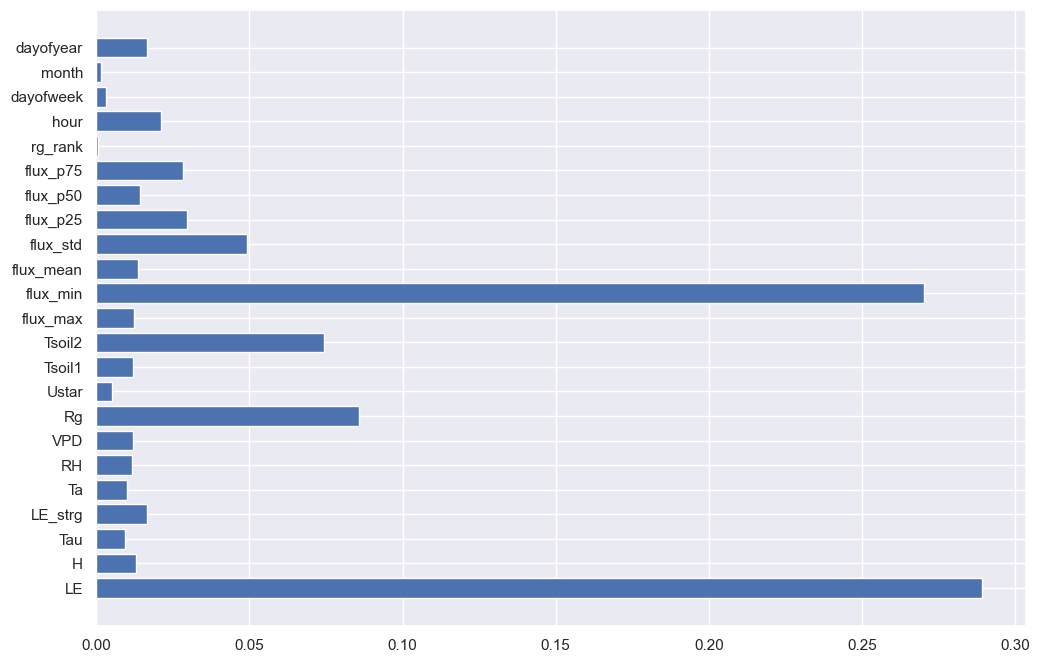

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.barh(columns_to_pick, feat_importances)

## Collective Study

In [20]:
train_data, test_data = split_data(data)

In [21]:
gap_scores_mds = {"very short": 0.0, "short": 0.0, "medium": 0.0, "week": 0.0, "long": 0.0, "month": 0.0}
gap_stds_mds = {"very short": 0.0, "short": 0.0, "medium": 0.0, "week": 0.0, "long": 0.0, "month": 0.0}

gap_scores_rfr = {"very short": 0.0, "short": 0.0, "medium": 0.0, "week": 0.0, "long": 0.0, "month": 0.0}
gap_stds_rfr = {"very short": 0.0, "short": 0.0, "medium": 0.0, "week": 0.0, "long": 0.0, "month": 0.0}

In [22]:
# MDS
for gap_type in gap_scores_mds.keys():
    train_data_with_gaps = insert_gaps_with_timestamps(train_data, gap_type)
    test_data_with_gaps = insert_gaps_with_timestamps(test_data, gap_type)
    # Fill gaps using MDS
    data_filled = fill_gaps_mds(train_data, test_data_with_gaps)
    # Calculate metrics
    r2, std_dev, filled_values = calculate_metrics(test_data, test_data_with_gaps, data_filled)

    gap_scores_mds[gap_type] = r2
    gap_stds_mds[gap_type] = std_dev

In [28]:
# RFR
for gap_type in gap_scores_rfr.keys():
    test_data_with_gaps = insert_gaps_with_timestamps(data, gap_type)
    # Fill gaps using MDS
    data_filled = fill_gaps_rfr(train_data, test_data_with_gaps)
    # Calculate metrics
    r2, std_dev, filled_values = calculate_metrics(test_data, test_data_with_gaps, data_filled)

    gap_scores_rfr[gap_type] = r2
    gap_stds_rfr[gap_type] = std_dev

<BarContainer object of 6 artists>

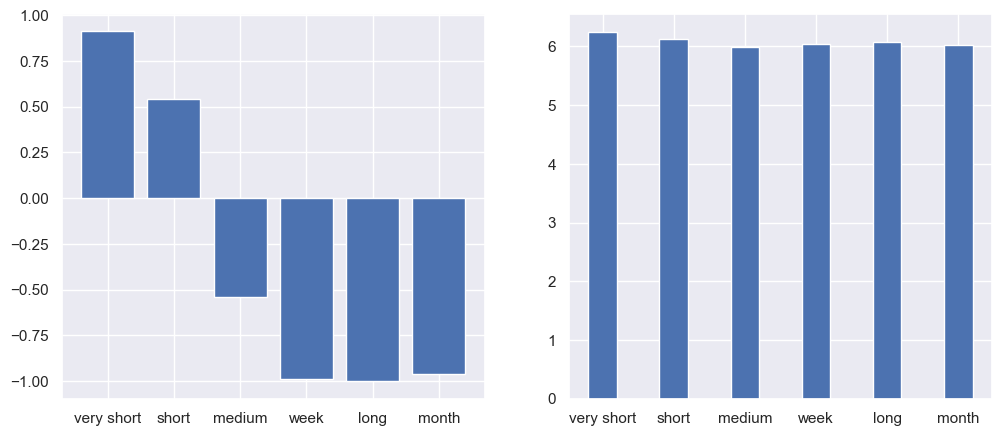

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].bar(gap_scores_mds.keys(), gap_scores_mds.values())
ax[1].bar(gap_stds_mds.keys(), gap_stds_mds.values(), width=0.4)

<BarContainer object of 6 artists>

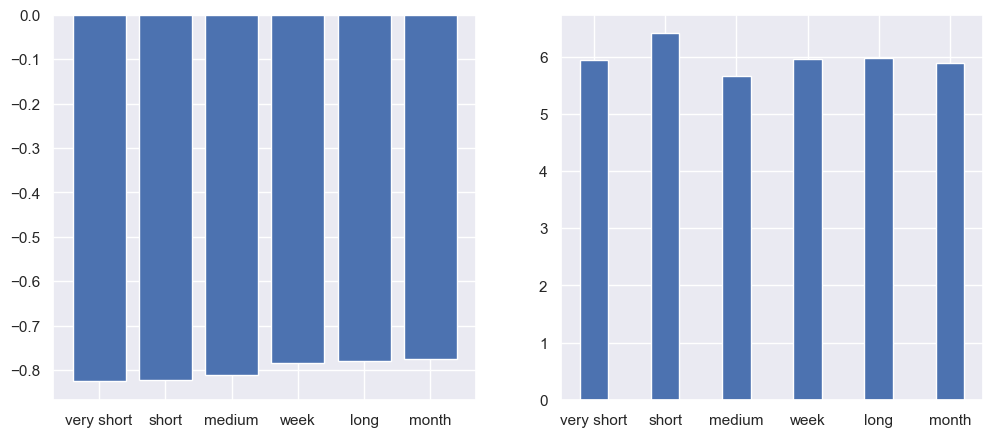

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].bar(gap_scores_rfr.keys(), gap_scores_rfr.values())
ax[1].bar(gap_stds_rfr.keys(), gap_stds_rfr.values(), width=0.4)